In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq

import muon as mu

import warnings
warnings.filterwarnings('ignore')

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
import matplotlib.pyplot as plt

In [3]:
import liana as li

In [4]:
## load slide
slide = "C1"
exp = "V11L12-109" # V11T17-102 V11L12-109 V11T16-085
slide_path = f"data/sma/{exp}/{exp}_{slide}/output_data"

In [5]:
mdata = mu.read_h5mu(os.path.join(slide_path, "sma.h5mu"))
rna = mdata.mod["rna"]
msi = mdata.mod["msi"]

HVG

In [6]:
sc.pp.highly_variable_genes(rna, flavor='cell_ranger', n_top_genes=500)
rna = rna[:, rna.var['highly_variable']]

In [7]:
sc.pp.highly_variable_genes(msi, flavor='cell_ranger', n_top_genes=50)

In [8]:
msi.var

,mean,std,mz,max_intensity,mz_raw,annotated,highly_variable,means,dispersions,dispersions_norm
name,,,,,,,,,,
156.26059,0.054031,0.209327,156.26,9.248456e+06,156.26059,NaN,False,0.000015,0.000156,-1.697950
156.26195,0.053002,0.216041,156.26,9.709658e+06,156.26195,NaN,False,0.000015,0.000196,-1.041784
156.48344,0.043413,0.192435,156.48,7.791353e+06,156.48344,NaN,False,0.000012,0.000188,-1.560041
156.4838,0.044560,0.197815,156.48,8.191085e+06,156.4838,NaN,False,0.000013,0.000216,-0.966551
156.485,0.047777,0.199507,156.49,8.323181e+06,156.485,NaN,False,0.000013,0.000171,-1.732839
...,...,...,...,...,...,...,...,...,...,...
1046.36442,0.039963,0.231604,1046.36,9.796245e+06,1046.36442,NaN,True,0.000015,0.000429,4.708579
1048.32025,0.043342,0.237810,1048.32,1.037273e+07,1048.32025,NaN,False,0.000016,0.000412,2.443542
1048.3319,0.053136,0.273897,1048.33,1.381839e+07,1048.3319,NaN,True,0.000022,0.000517,4.230426


In [9]:
msk = (msi.var.index.isin(msi.var['annotated']) + msi.var['highly_variable'])

In [10]:
msi = msi[:, msk].copy()

Test

In [11]:
# get reference coordinates
reference = mdata.mod["rna"].obsm["spatial"]


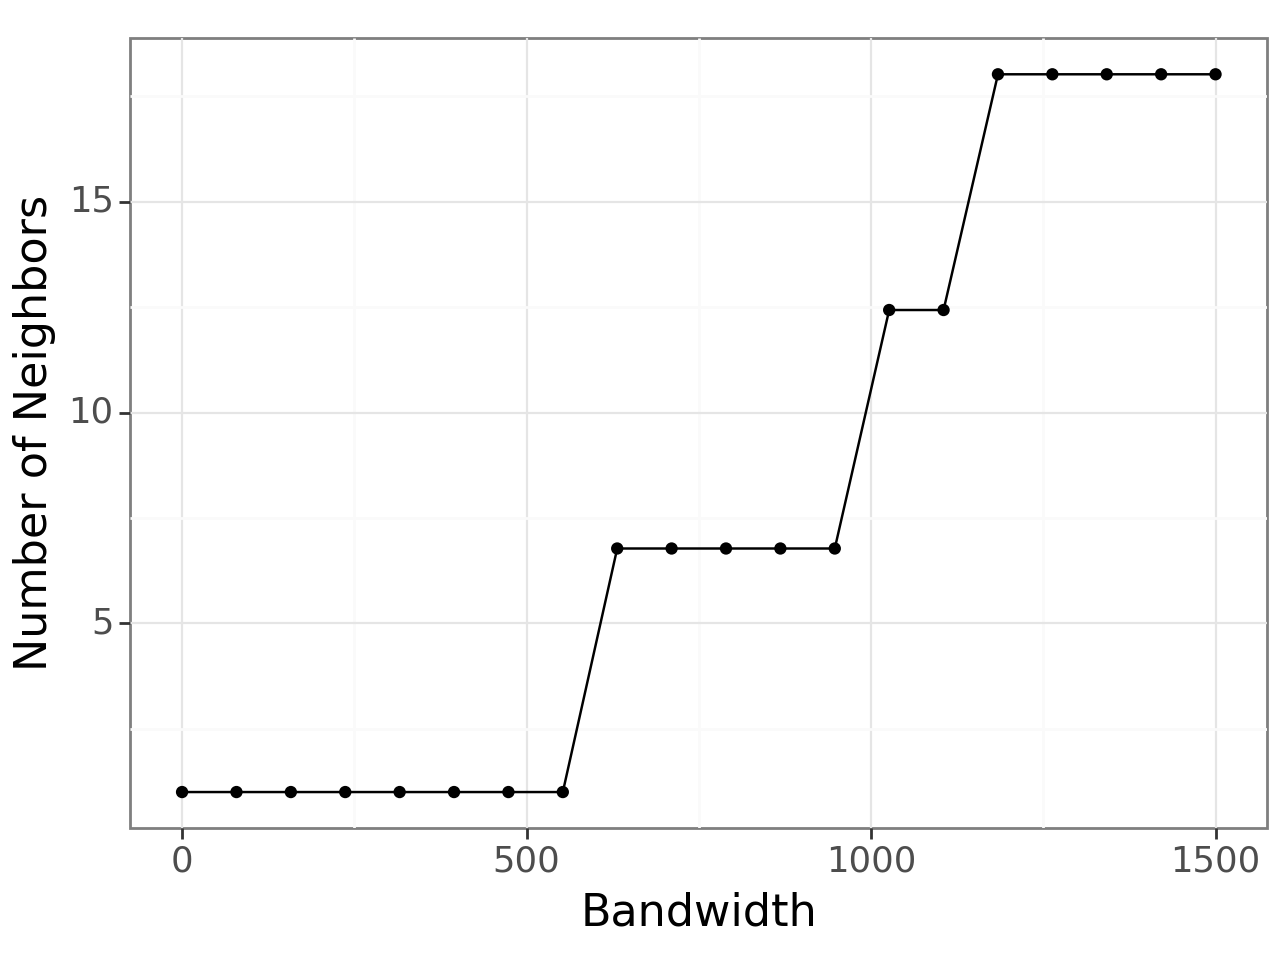

<Figure Size: (640 x 480)>

In [12]:
plot, _ = li.ut.query_bandwidth(coordinates=rna.obsm['spatial'], start=0, end=1500, interval_n=20, reference=reference)
plot

In [13]:
# distances of metabolties to RNA
li.ut.spatial_neighbors(msi, bandwidth=1000, cutoff=0.1, spatial_key="spatial", reference=reference, set_diag=False, standardize=False)

In [14]:
# get reference coordinates
reference = mdata.mod["msi"].obsm["spatial"]

# distances of metabolties to RNA
li.ut.spatial_neighbors(rna, bandwidth=500, cutoff=0.1, spatial_key="spatial", reference=reference, set_diag=False, standardize=False)

In [15]:
sq.pl.spatial_scatter(msi, color="Dopamine (double)")

In [16]:
# spatial weight all as 1
w = np.zeros((msi.obsm['spatial_connectivities'].T.shape))

In [17]:
w = msi.obsm['spatial_connectivities'].T

In [18]:
# Apply Spatial Smoothing with RNA as reference
msi_smooth = w @ msi.X
msi_smooth = sc.AnnData(X=msi_smooth, obs=rna.obs, obsm=rna.obsm, uns=rna.uns, var=msi.var)

In [19]:
sq.pl.spatial_scatter(msi_smooth, color="Dopamine (double)")

Mitsy

In [20]:
mdata.update_obs()

In [21]:
misty = li.mt.MistyData({"intra": msi, "inter":rna}, enforce_obs=False, obs=mdata.obs)


view intra is not a csr_matrix. Converting to csr_matrix


In [22]:
misty(model="linear", verbose=True, bypass_intra=True)

Now learning: 1048.38431: 100%|██████████| 56/56 [03:36<00:00,  3.86s/it]       


In [23]:
misty.uns['target_metrics'].sort_values("gain_R2", ascending=False).head(10)

,target,intra_R2,multi_R2,gain_R2,inter
24,674.28833,0,0.814508,0.814508,1.0
1,390.16864,0,0.786809,0.786809,1.0
12,3-MT,0,0.772725,0.772725,1.0
23,674.28592,0,0.748117,0.748117,1.0
25,675.29202,0,0.647237,0.647237,1.0
11,431.08294,0,0.606879,0.606879,1.0
22,Dopamine (double),0,0.558826,0.558826,1.0
15,555.20345,0,0.399592,0.399592,1.0
16,555.20713,0,0.390112,0.390112,1.0
17,569.20536,0,0.384700,0.384700,1.0


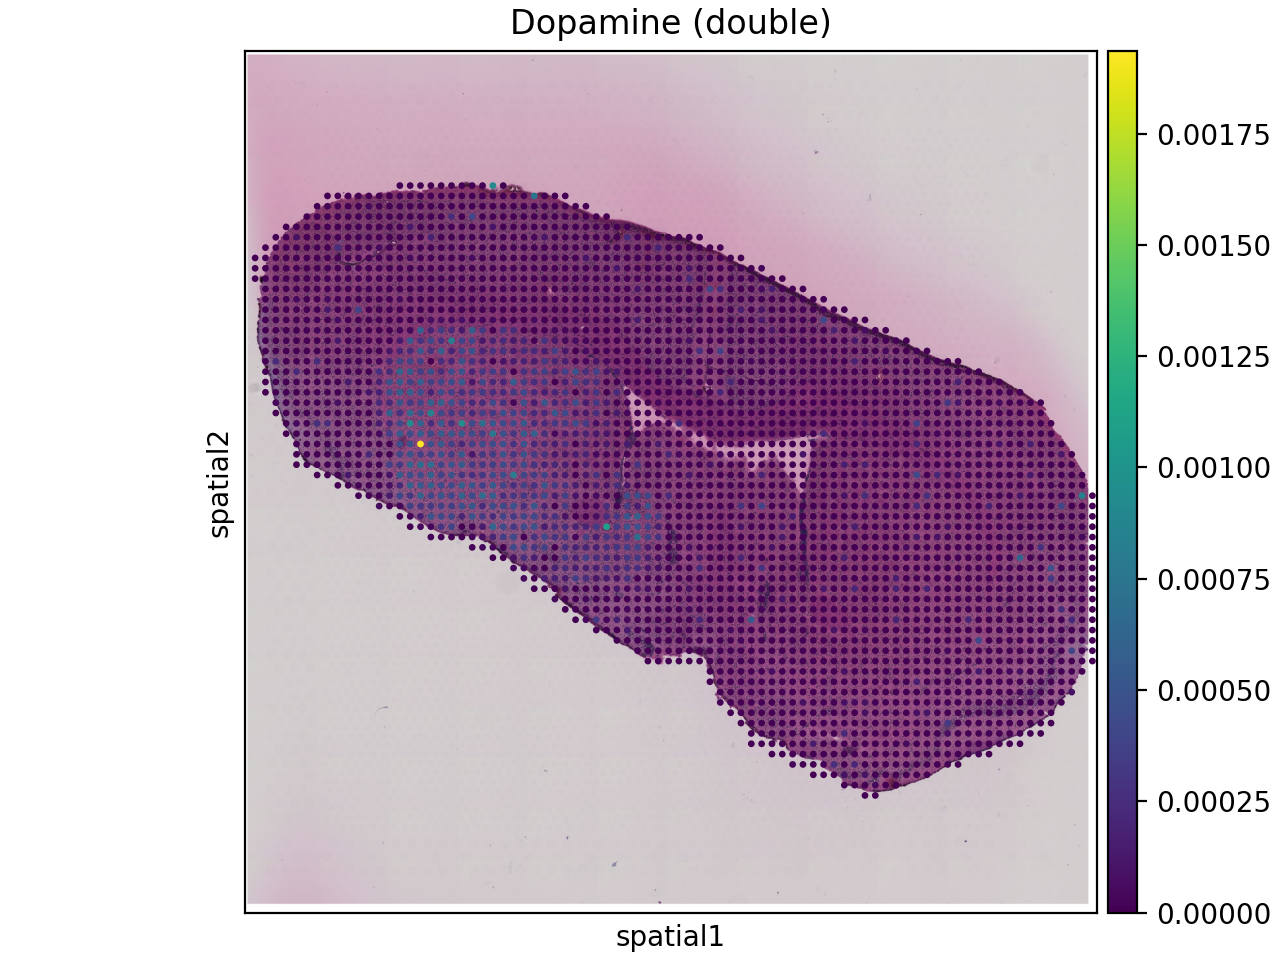

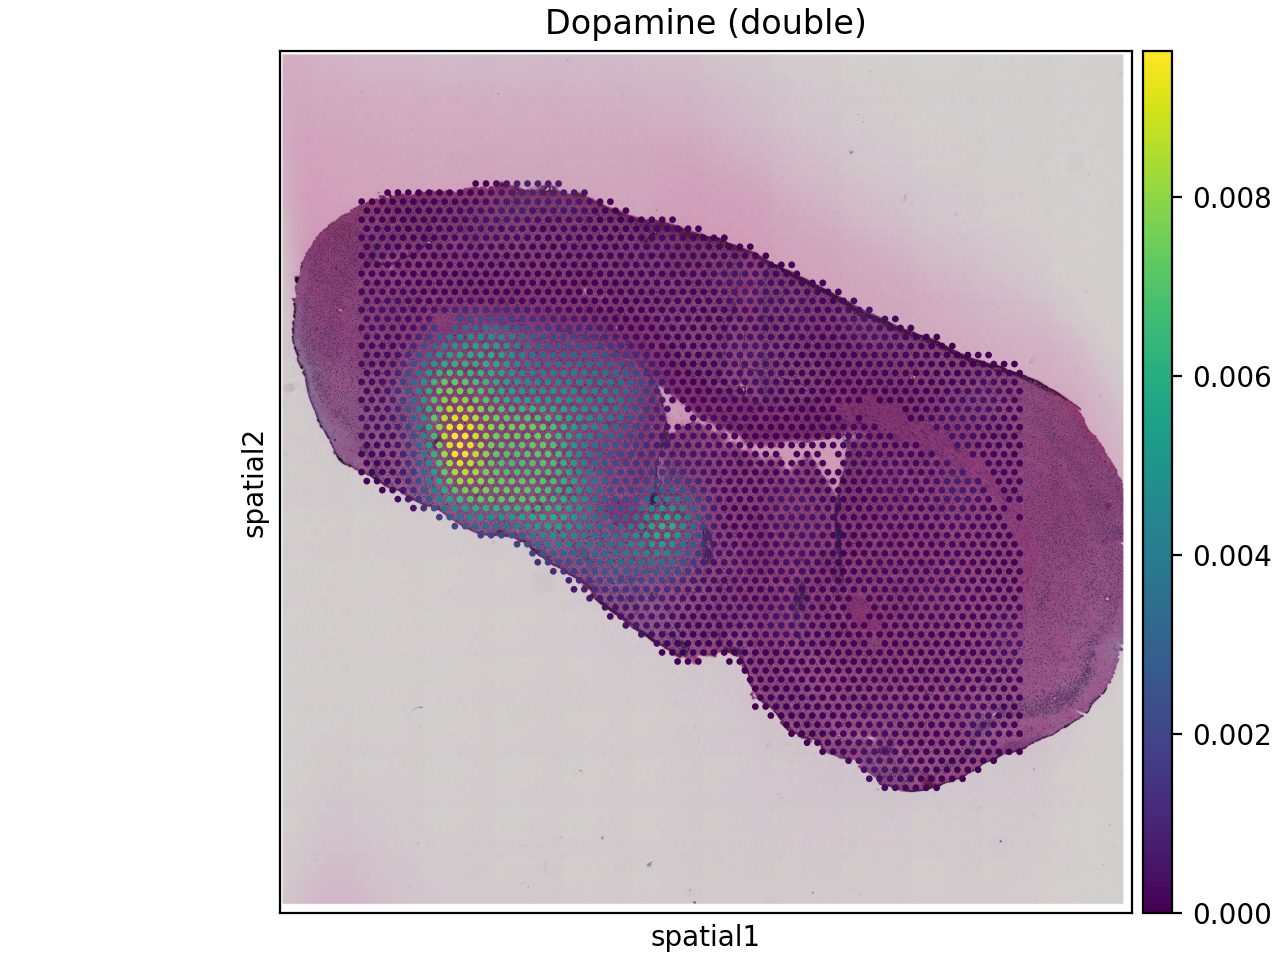

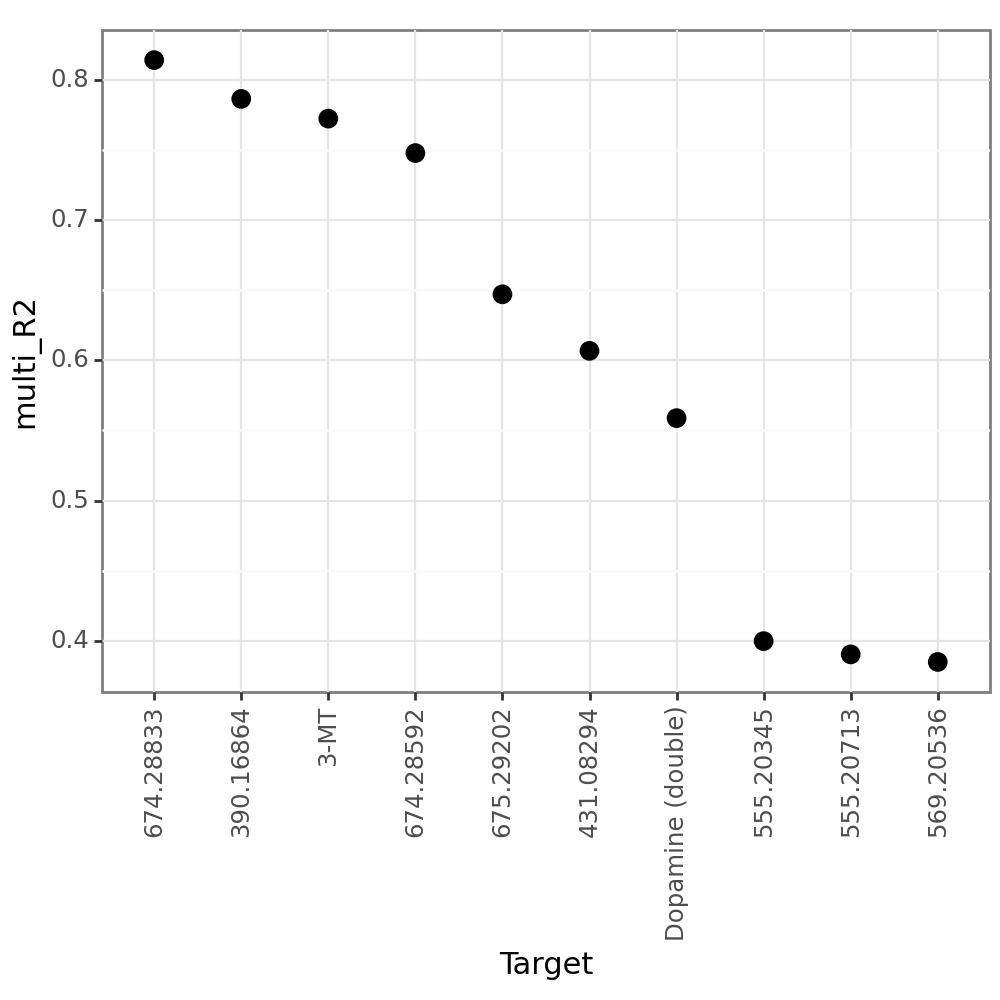

<Figure Size: (500 x 500)>

In [24]:
li.pl.target_metrics(misty, stat='multi_R2', top_n=10, return_fig=True)

In [25]:
metab = '674.28833' # '551.23688'
misty.uns['interactions'][misty.uns['interactions']['target'] == metab].sort_values("importances", key=abs, ascending=False).head(30)

,target,predictor,view,importances
12337,674.28833,Penk,inter,-19.602921
12051,674.28833,Cacng4,inter,10.688171
12390,674.28833,Rreb1,inter,-8.574515
12445,674.28833,Tac1,inter,8.378913
12398,674.28833,Scn4b,inter,7.794777
12262,674.28833,Lrrc10b,inter,5.365696
12139,674.28833,Fam163b,inter,5.362131
12356,674.28833,Ppp1r1b,inter,5.360688
12257,674.28833,Lbhd2,inter,5.275871
12259,674.28833,Lingo1,inter,-5.167607


In [ ]:
# Apply Spatial Smoothing with RNA as reference
w2 = li.ut.spatial_neighbors(rna, bandwidth=500, cutoff=0.1, spatial_key="spatial", inplace=False, set_diag=False, standardize=False)
rna.layers['smooth'] = w2 @ rna.X

In [ ]:
rna_smooth = rna[:, 'Pdyn'].layers['smooth'].copy()

In [ ]:
sc.AnnData(msi_smooth[:,'Dopamine (double)'].X * rna_smooth.A.flatten())

In [ ]:
import muon as mu

In [ ]:
mdata = mu.MuData({'rna':rna, 'msi':msi_smooth}, obs=rna.obs, uns=rna.uns)

In [ ]:
mdata

In [ ]:
from scipy.sparse import csr_matrix
w3 = np.zeros((mdata.shape[0], mdata.shape[0]))
w3 = csr_matrix(w3)
w3.setdiag(1)
mdata.obsp['spatial_connectivities'] = w3

In [ ]:
mdata

In [ ]:
li.mt.bivar(mdata, function_name='product', x_mod='rna', y_mod='msi', x_layer='smooth', x_use_raw=False, y_use_raw=False, verbose=True, interactions = [('Pdyn', 'Dopamine (double)')])

In [ ]:
mdata.mod['local_scores'].obsm = rna.obsm

In [ ]:
sq.pl.spatial_scatter(mdata.mod['local_scores'], color=['Pdyn^Dopamine (double)', 'lesion'])

In [ ]:
plt.show()

In [ ]:
mdata.mod['local_scores'].obs